In [20]:
pip install --upgrade pip

In [21]:
pip install control

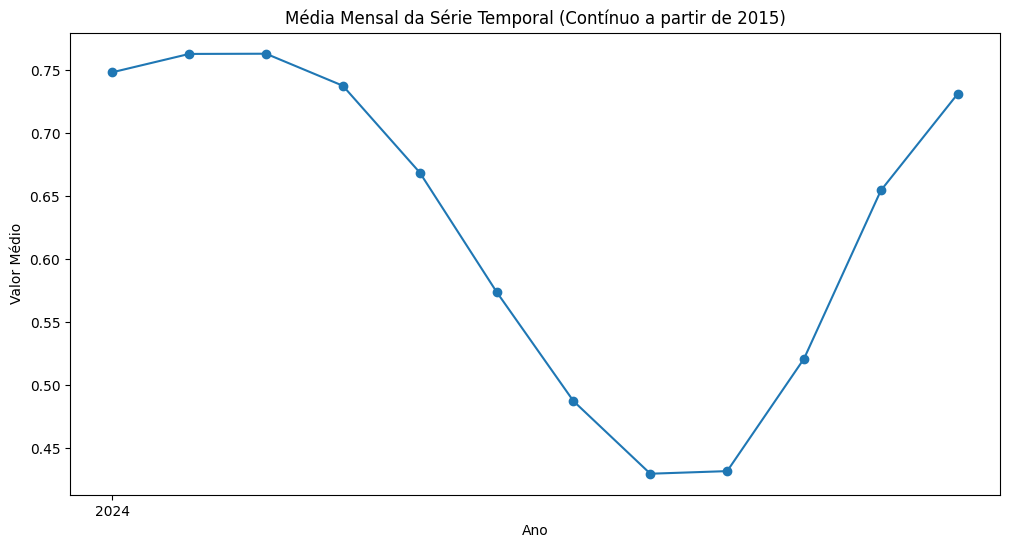

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("bra-ndvi-adm2-5ytd.csv", skiprows=1)

# Divinóplis BR3122306
df = df[df['#adm2+code'] == 'BR3122306']

df['#date'] = pd.to_datetime(df['#date'], errors='coerce')
df = df.dropna(subset=['#date'])

df['year'] = df['#date'].dt.year
df['month'] = df['#date'].dt.month

df = df[df['year'] == 2024]

df['time_index'] = df['year'] + (df['month'] - 1) / 12  

time_series_avg = df.groupby('time_index')['#indicator+vim+num'].mean()

plt.figure(figsize=(12,6))
plt.plot(time_series_avg.index, time_series_avg.values, marker='o', linestyle='-')

plt.xlabel("Ano")
plt.ylabel("Valor Médio")
plt.title("Média Mensal da Série Temporal (Contínuo a partir de 2015)")

years = range(df['year'].min(), df['year'].max() + 1)
plt.xticks(ticks=years, labels=[str(y) for y in years])

plt.show()


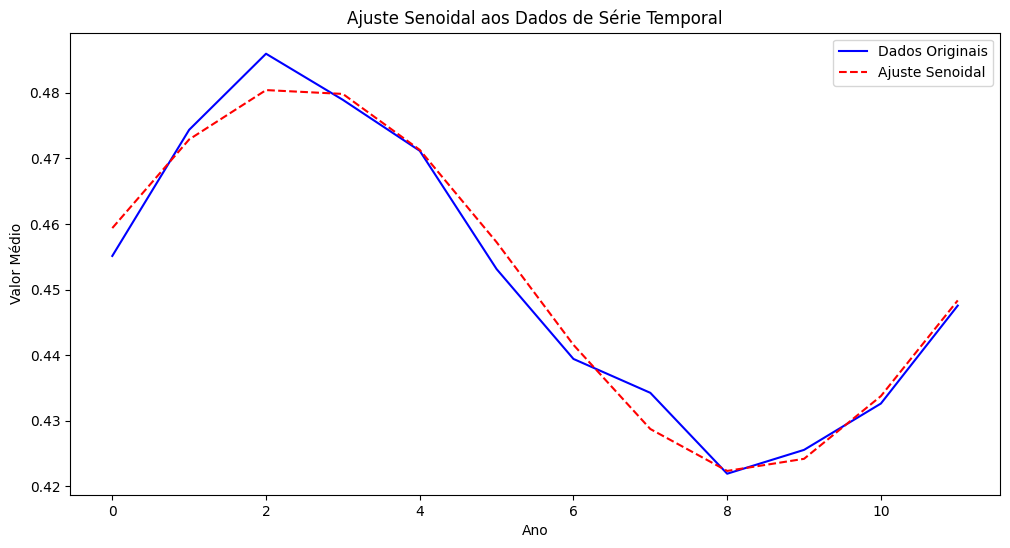

[ 0.02959303 -0.53701725  2.87605435  0.45161709]


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv("bra-ndvi-adm2-5ytd.csv", skiprows=1)
df = df[df['#adm2+code'] == 'BR4314902']

df['#date'] = pd.to_datetime(df['#date'], errors='coerce')
df = df.dropna(subset=['#date'])

# Criar colunas separadas para ano e mês
df['year'] = df['#date'].dt.year
df['month'] = df['#date'].dt.month

# Filtrar apenas os anos a partir de 2015
df = df[df['year'] == 2023]

df['time_index'] = df['year'] + (df['month'] - 1) / 12

# Agrupar por esse novo índice e calcular a média
time_series_avg = df.groupby('time_index')['#indicator+vim+num'].mean()

# Normalizar o índice para facilitar o ajuste (usando o número de dias desde o início)
time_series_avg.index = range(0, len(time_series_avg.index))

# Função seno para ajustar aos dados
def seno(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

# Ajustar o modelo senoidal aos dados
popt, _ = curve_fit(seno, time_series_avg.index, time_series_avg.values, p0=[1, 0.1, 0, 0], maxfev=10000)

# Plotando os resultados
plt.figure(figsize=(12, 6))
plt.plot(time_series_avg.index, time_series_avg.values, label="Dados Originais", color='blue')
plt.plot(time_series_avg.index, seno(time_series_avg.index, *popt), label="Ajuste Senoidal", color='red', linestyle='--')
plt.xlabel("Ano")
plt.ylabel("Valor Médio")
plt.title("Ajuste Senoidal aos Dados de Série Temporal")
plt.legend()
plt.show()


print(popt)

In [88]:
import sympy as sp

# [-8.01530935e-02  5.82186431e+00 -1.15790523e+04  6.72063652e-01]


# Definindo as variáveis simbólicas
x, s = sp.symbols('x s')

# Definindo os parâmetros A, B, C, D
[A, B, C, D] = popt

# Função f(x)
f_x = A * sp.sin(B * x + C) + D

# Transformada de Laplace de f(x)
F_s = sp.laplace_transform(f_x, x, s)

# Exibindo a transformada de Laplace
F_s


(-0.029593027101092*(-0.262428743781468*s - 0.518195537780798)/(s**2 + 0.28838753176314) + 0.451617089154502/s,
 0,
 True)

In [89]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Definindo as variáveis simbólicas
x, s = sp.symbols('x s')

# Definindo os parâmetros A, B, C, D (substitua popt com os valores reais)
A, B, C, D = popt # Exemplo de parâmetros

# Função f(x)
f_x = A * sp.sin(B * x + C) + D

# Transformada de Laplace de f(x)
F_s = sp.laplace_transform(f_x, x, s)[0]  # Pegando a transformada de Laplace (descartando condições iniciais)

F_s


-0.029593027101092*(-0.262428743781468*s - 0.518195537780798)/(s**2 + 0.28838753176314) + 0.451617089154502/s

<TransferFunction>: sys[36]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.4594 s^2 + 0.01533 s + 0.1302
-------------------------------
        s^3 + 0.2884 s

<TransferFunction>: sys[39]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  0.4594 s^5 + 0.01533 s^4 + 0.2627 s^3 + 0.004422 s^2 + 0.03756 s
--------------------------------------------------------------------
s^6 + 0.4594 s^5 + 0.5921 s^4 + 0.2627 s^3 + 0.08759 s^2 + 0.03756 s



(0.459383150081332*s**2 + 0.0153349745932121*s + 0.130240737643321)/(s*(1.0*s**2 + 0.28838753176314))

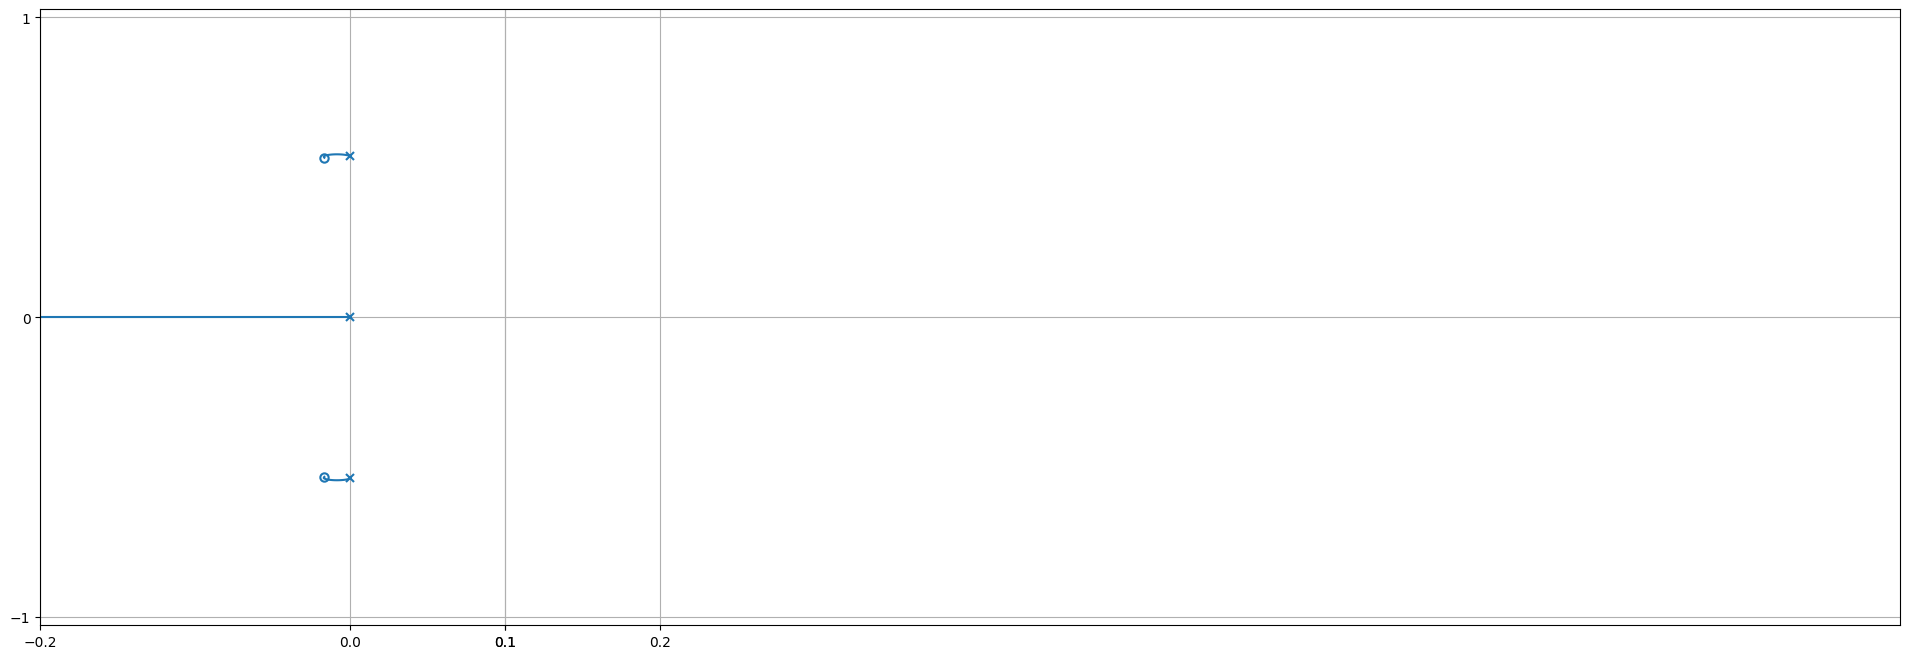

In [90]:
import control as ctrl


def add_plot(tf, k, ax):
  t, y = ctrl.step_response(tf)
  ax.plot(t, y, label=f'k={k}')
  ax.grid()
  ax.legend()

def add_rlocus(tf, ax):
    ctrl.rlocus(tf, ax=ax)
    
    ax.set_xticks([-0.2, 0.1, 0, 0.1, 0.2])

    ax.set_yticks([-1, 0, 1])
    ax.grid()

# Get the numerator and denominator
H_s = sp.simplify(F_s)  # Simplify expression
num, den = sp.fraction(H_s)  # Extract numerator and denominator

# Convert to polynomials
num_poly = sp.Poly(num, s)
den_poly = sp.Poly(den, s)

# Extract coefficients
num_coeffs = [float(c) for c in num_poly.all_coeffs()]
den_coeffs = [float(c) for c in den_poly.all_coeffs()]

# Create transfer function
H_tf = ctrl.TransferFunction(num_coeffs, den_coeffs)

# Print the transfer function
print(H_tf)

X = H_tf / (1 + H_tf)

print(X)

fig, ax = plt.subplots(1, 1, figsize=(24, 8))

add_rlocus(H_tf, ax)
H_s


In [ ]:
import sympy
from tbcontrol.symbolic import routh


K_c = sympy.Symbol('K_c')

ce = s**6 + 0.7109*s**5 + 0.06366*s**4 + 0.0361*s**3 + 0.0009805*s**2 + 0.000458*s + K_c  

A = routh(sympy.Poly(ce, s))

a = sympy.solve([e > 0 for e in A[:, 0]], K_c)

print(a)

A

(1.26438667923194e-9 < K_c) & (K_c < oo) & (((2.4165581330629e-8 < K_c) & (K_c < 4.34142067693715e-7)) | ((-oo < K_c) & (K_c < 1.26438667923194e-9)))


Matrix([
[                                                                                                                     1.0,                        0.06366, 0.0009805, 1.0*K_c],
[                                                                                                                  0.7109,                         0.0361,  0.000458,       0],
[                                                                                                       0.012879299479533,           0.000336246237164158,   1.0*K_c,       0],
[                                                                                                      0.0175401823344613, 0.000458 - 55.197101451808*K_c,         0,       0],
[                                                                              40.5297953262032*K_c - 5.12453333224482e-8,                        1.0*K_c,         0,       0],
[(-2237.12722444145*K_c**2 + 0.00102529251880212*K_c - 2.34703626616813e-11)/(40.5297953262032*K_c - 5.12453333

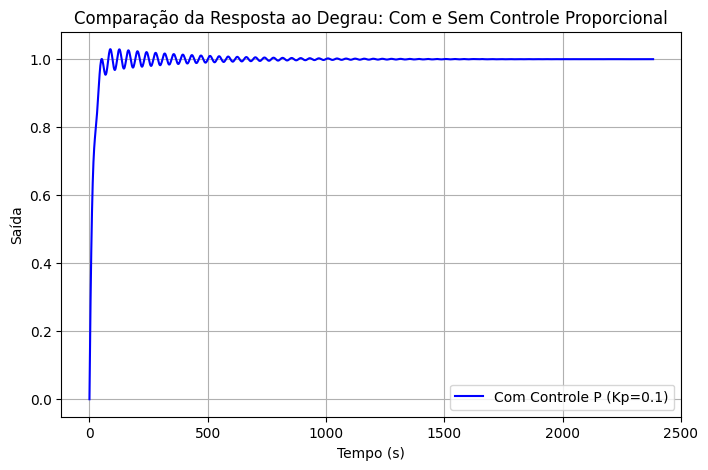

In [96]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

# Define the plant transfer function G(s)
G = H_tf

# Define the proportional gain (P controller)
Kp = 0.1
   # Adjust this value as needed

# Sistema sem controle (Malha Aberta)
time_no_control, response_no_control = ctrl.step_response(G)

# Sistema com controle proporcional (Malha Fechada com P-Control)
P_controller = ctrl.TransferFunction([Kp], [1])  # Apenas um ganho
open_loop = P_controller * G
closed_loop = ctrl.feedback(open_loop)  # Feedback negativo
time_with_control, response_with_control = ctrl.step_response(closed_loop)

# Plotando os resultados
plt.figure(figsize=(8, 5))
# plt.plot(time_no_control, response_no_control, label="Sem Controle (Malha Aberta)", linestyle="--", color="red")
plt.plot(time_with_control, response_with_control, label=f"Com Controle P (Kp={Kp})", linestyle="-", color="blue")
plt.xlabel("Tempo (s)")
plt.ylabel("Saída")
plt.title("Comparação da Resposta ao Degrau: Com e Sem Controle Proporcional")
plt.grid()
plt.legend()
plt.show()